# Primerjava Covid 19 z gripo, vpliv ukrepov, vpliv povprečne starosti populacije države na smrtnost !

In [37]:
import pandas as pandas
import os
import sys
import json
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets      import Dropdown
from bqplot          import Lines, Figure, LinearScale, DateScale, Axis
from ipyleaflet      import Map, GeoJSON, WidgetControl
from ipywidgets import IntSlider, ColorPicker, ToggleButton
import numpy as np
from collections import defaultdict
from scipy.stats import multivariate_normal as mvn
%matplotlib inline
sys.path.append(os.getcwd() + '/modules')
from zansModule     import read_population_by_sex, get_sum_population_array, my_round, get_age_distribution_array
from zansModule     import draw_bar_chart_distribution, draw_bar_chart_mortality, death_count_country_year, month_deaths
import nikolajPModule as nicx
#from enejBModule    import test_enej
from jakaRModule    import test_jaka
from nikolajPModule import test_nikolaj
from rokSModule import drawPlot, compare, showCountermeasures
main_setNP = nicx.read_population_by_spol()
smr_tNP,smr_gpNP,smr_plNP,smr_gNP,seasonNP,StateNP = nicx.read_csv()
matricaNP,americaNP = nicx.matricaRead()
matricaNP = np.array(matricaNP)
# reading data from files
with open('../podatki/countries.geo.json') as f:
    countries_geo = json.load(f)
pop_by_sex = read_population_by_sex()  

reader = pandas.read_csv("../podatki/corona_worldwide.csv")
virus_array = reader.to_numpy()    #create array of data

In [38]:
def display_data_for_country(country_name, year, show_bool):
    print("Država: " + country_name + "\nLeto: " + str(year))
    pop_data_set = get_sum_population_array(pop_by_sex, country_name)
    rounded_year = my_round(year)
    
    avg_age = float(pop_by_sex[(pop_by_sex['Region-Country'] == country_name) & (pop_by_sex["Date"] == rounded_year)]["avg_age"])
    this_year_pop = [i for i in pop_data_set if i[0] == rounded_year]
    avg_deaths = month_deaths(death_count_country_year(country_name, year))
    
    if type(avg_deaths[0]) is float:
        avg_deaths = int(avg_deaths[0]), int(avg_deaths[1])
    
    print("Populacija v tej državi leta {} je {:.2f} tisoč".format(rounded_year, this_year_pop[0][1]))
    print("Povprečna starost prebivalca v tej državi leta {} je bila {:.1f}".format(rounded_year, avg_age))
    print("V tej državi je vsak mesec leta {} umrlo povprečno {} ljudi. V celem letu pa {} ljudi"
          .format(year, str(avg_deaths[0]), str(avg_deaths[1])))
    
    if show_bool:
        draw_bar_chart_distribution(get_age_distribution_array(pop_by_sex, country_name, rounded_year), country_name, rounded_year)
        draw_bar_chart_mortality(year, year-1, country_name)

## Interaktivni zemljevid, ki izpiše št. prebivalcev, povprečno starost prebivalcev, št. ljudi ki je v tej državi umrlo v danem letu ter kako je Covid-19 vplival nanjo

In [39]:
import time
m = Map(zoom=3)

geo = GeoJSON(data=countries_geo, style={'fillColor': 'white', 'weight': 0.5}, hover_style={'fillColor': '#1f77b4'}, name='Countries')

year_slider = IntSlider(description='Year:', min=1980, max=2020, value=2018)
slider_control = WidgetControl(widget=year_slider, position='topright')
m.add_control(slider_control)

show_graphs = ToggleButton(description='Show Graph')
button_control = WidgetControl(widget=show_graphs, position='topright')
m.add_control(button_control)

def click_handle(event=None, feature=None, **kwargs): # must be none if nothing is given

            year = year_slider.value
            clear_output(True)
        #
            try:
                display_data_for_country(kwargs['properties']['name'], year, show_graphs.value)
                drawPlot(virus_array, kwargs['properties']['name'], "both")
                showCountermeasures(kwargs['properties']['name'])
                display(m)
            except:
                pass

            
geo.on_click(click_handle)
m.add_layer(geo)
display(m)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Graf za Covid-19 je narejen od prvega dne, ko se je virus pojavil v določeni državi. Prikazoval naj bi hitrost širjenja virusa in s tem tudi število posledično umrlih ljudi. Prav tako bi se ob izbiri države morali prikazati ukrepi, ki jih je država sprejela za preprečitev širjenja virusa, vendar nam je to uspelo narediti le za 2 državi (Slovenijo ter VB) zaradi težavnosti pri iskanju podatkov - vse podakte bi morali prepisati ročno.


Za prikaz širjenja Covid-19 je napisana tudi funkcija __compare(država1, država2, query)__ -> _query = {"cases", "deaths"}._

S njo lahko prikažemo ter primerjamo dve državi po hitrosti naraščanja primerov oz. smrti (to izberemo v "query"). Zaradi izredne velike razlike med nekaterimi državami, je graf lahko v nekaterih primer precej nerazviden, ampak je zato v državah s približnim enakim rastom/številom ker všečen.

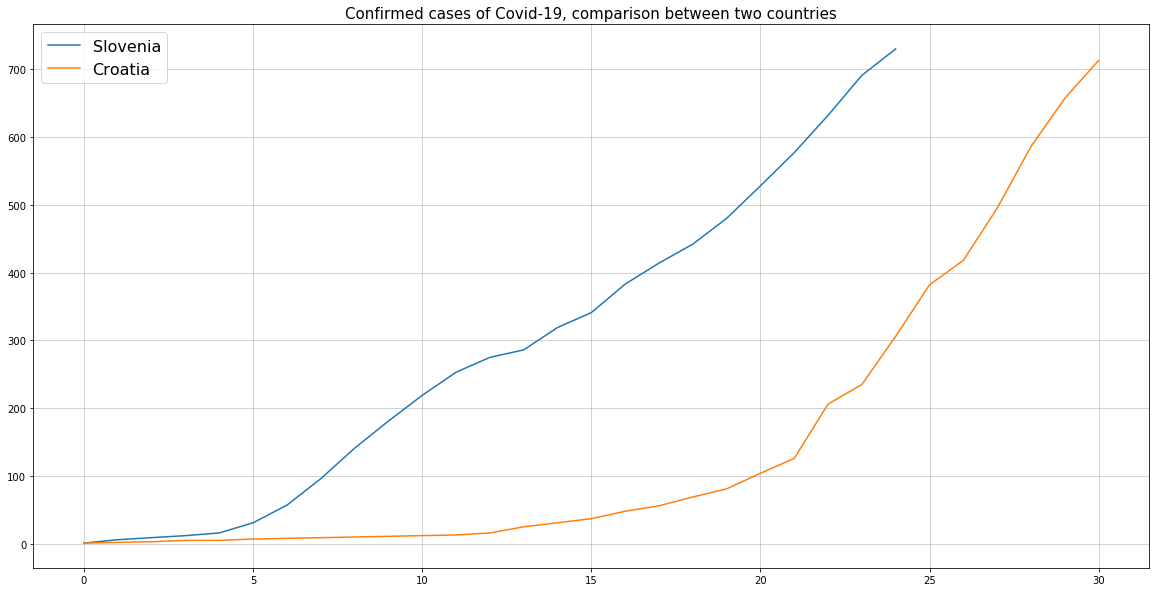

In [40]:
compare(virus_array, "slovenia", "croatia", "cases")

In [41]:
"""
BACKUP CODE - ŽAN

m = Map(zoom=3)

geo = GeoJSON(data=countries, style={'fillColor': 'white', 'weight': 0.5}, hover_style={'fillColor': '#1f77b4'}, name='Countries')

year_slider = IntSlider(description='Year:', min=1980, max=2020, value=2018)
slider_control = WidgetControl(widget=year_slider, position='topright')
m.add_control(slider_control)

show_graphs = ToggleButton(description='Show Graph')
button_control = WidgetControl(widget=show_graphs, position='topright')
m.add_control(button_control)

def click_handle(event=None, feature=None, **kwargs): # must be none if nothing is given
    if feature is not None:
        year = year_slider.value
        clear_output(True)
        display(m)
        display_data_for_country(kwargs['properties']['name'], year, show_graphs.value)

geo.on_click(click_handle)
m.add_layer(geo)
display(m)

"""
clear_output(True)

## Primerjava smrtnosti za Francijo in Anglijo leto 2019 in 2020

## Primerjava rasti COVID okužb po državah

In [42]:
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import jakaRModule as jaka

In [43]:
# Read data for Covid-19 growth comparison
(dataFrame,dateRange,countries) = jaka.readGrowthData()

C:\Users\Nikolaj\direttaudirettori\PR20NERJZ\notebooks/modules\jakaRModule.py:16: FutureWarning: read_table is deprecated, use read_csv instead.
  "../podatki/corona_latest.csv", sep=",", usecols=[0, 4, 5, 6, 9])


In [44]:
# Create a dictionary, containing weekly statistics
weeklyStatsDict = jaka.createWeeklyStatsDict(dataFrame,dateRange,countries)

##### Opis podatkov

V prejšnjem koraku ima vsaka država za vsak teden od začetka beleženja Covid-19 število okuženih in mrtvih. Če bi gručili po teh podatkih, bi populacija države igrala veliko vlogo. Ker pa tega nočemo (primerjamo le rast), se v naslednjem koraku za vsak teden izračuna razmerje naslednji/prejšnji teden. S tem dobimo za vsak teden nek koeficient, ki prikazuje rast števila okuženih oziroma mrtvih. Ko gručimo na ta način, populacija ne igra vloge.

In [45]:
# Create a dictionary, that contains growth coefficients for every week in date range
weeklyCoefficientsDict = jaka.createWeeklyCoefficientsDict(weeklyStatsDict)

In [46]:
# Create matrices for later use in model creation
(caseMatrix, deathMatrix, labels) = jaka.createMatricesAndLabels(weeklyCoefficientsDict, 100)

In [47]:
caseLinkage = jaka.createLinkage(caseMatrix)
deathLinkage = jaka.createLinkage(deathMatrix)

In [48]:
%matplotlib inline
# jaka.drawDendrogram(caseLinkage, labels, title="Države, gručene po tedenskem koeficientu rasti okuženih")

Za prikaz podatkov smo izbrali dendrogram, saj po našem mnenju lepo grafično prikazuje rezultate. Na grafu vidimo, katere države so si podobne glede na to, kakšna je bila rast števila mrtvih za Covid-19.

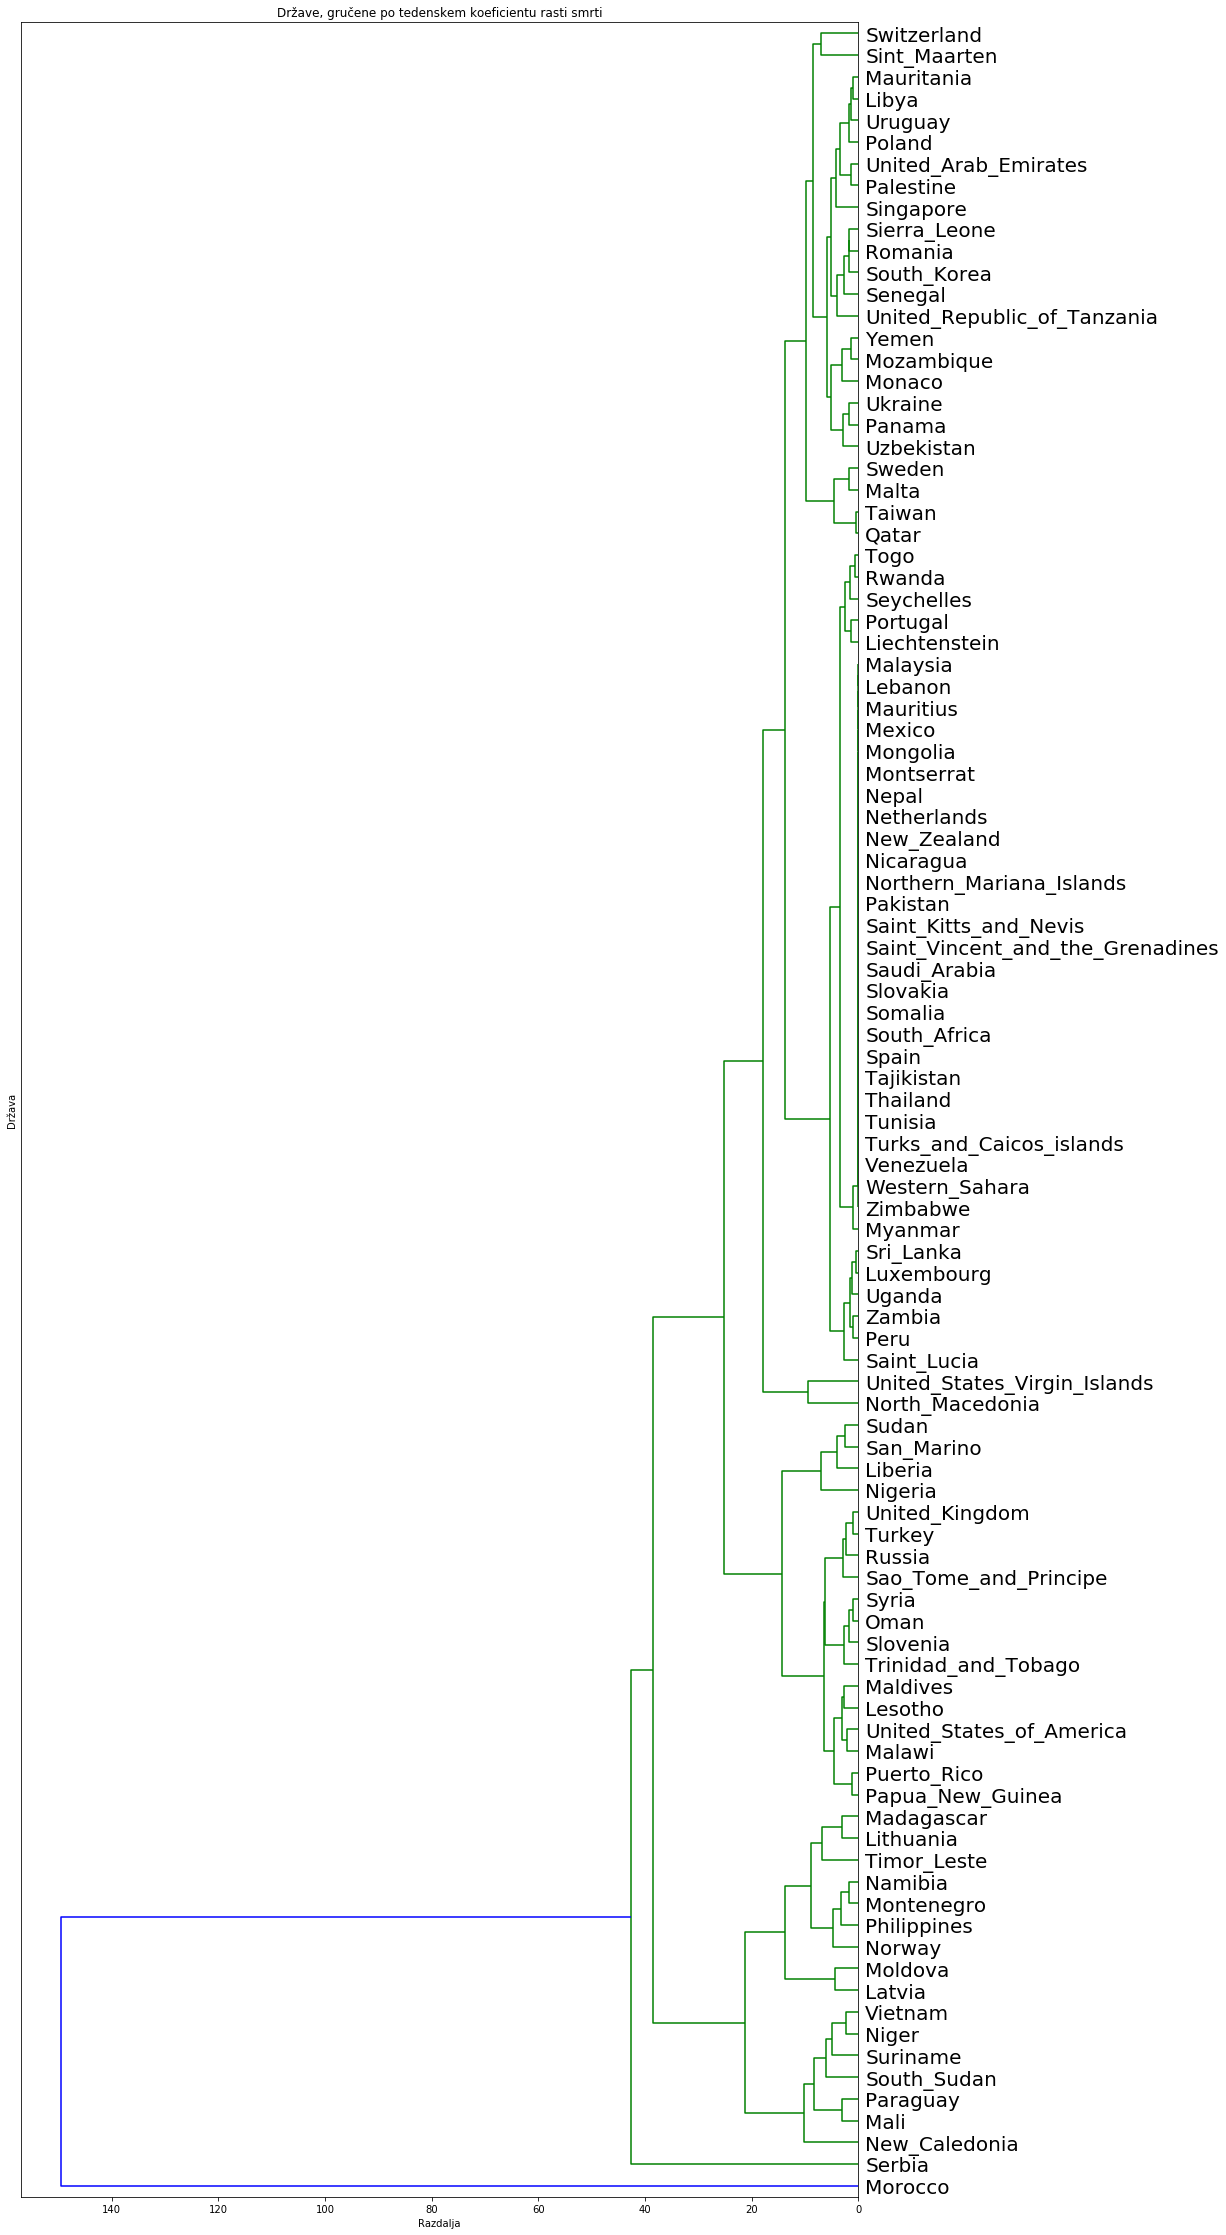

In [49]:
jaka.drawDendrogram(deathLinkage, labels, title="Države, gručene po tedenskem koeficientu rasti smrti")

## Gručenje držav glede na mesečno umrljivost

In [50]:
# Read total population data
(dataFrame, countryList) = jaka.readTotalPopulationData()

C:\Users\Nikolaj\direttaudirettori\PR20NERJZ\notebooks/modules\jakaRModule.py:118: FutureWarning: read_table is deprecated, use read_csv instead.
  populationFrame = pd.read_table("../podatki/total_population_by_sex.csv",sep=",",usecols=[1,4,8])


In [51]:
# Year months for later use
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [52]:
# Read the dataframe which contains deaths per month for year 2015
deathDataFrame = jaka.readDeathData(year=2015)

C:\Users\Nikolaj\direttaudirettori\PR20NERJZ\notebooks/modules\jakaRModule.py:132: FutureWarning: read_table is deprecated, use read_csv instead.
  deathFrame = pd.read_table("../podatki/unData_deaths_per_month.txt",sep=";",usecols=[0,1,3,7],skiprows=range(39282,39400))


# Gručenje po podatkih o starosti

Hierarhično gručenje na podatkovni množici, kjer iščemo podobnosti med starostnimi distribucijami med drzavami - gledamo katere države imajo podobno porazdeljeno starost prebivalcev. Črna: Prebivalci drzac ZAE, OMAN, Maldivi ,Qatar , Bahrain -> Glede na znana dejstva smiselen izbor vsaj za strukturo starosti, socialno ekonomske razmire, tip gospodarstva, kulturo.Pričakuje se malo smrti. Rumena: Belize, Cambodia, South africa, South sudan kulturno podbne države, po večini afrika in otoki. Vijolična: Otočja, države latinske amerike, nekaj držav področja bivšega bizanca. Svetlomodra: Po večini predstavniki afrike, kar je smiselno glede na to, da je starostna porazdelitev na afriski celini precej, drugačna kakor npr. v evropi saj je življenski standard precej nizji, posledicno ljudje umirajo zaradi v drugim celinam trivialnih bolezni, tudi sociološki standardi se na tej točki odcepijo od črne skupine zato vrjento tudi zaznana drugačna starostna sestava.Pričakuje se manj smrti zaradi precejšne razseljenosti prebivalstva in nizkih standardov, pa tudi nekaj več zaradi slabe zdravstvene oskrbe. Zelena: Povečini države razvitejšega sveta(Evropske), nekaj otočja, Azije po večini države razvitejšega sveta, kjer je zaradi višjega razvoja civilizacije pričakovana starost višja. Najpogostejše žrtve COVID-19 ponavadi presegajo 70 let, teh je na tem območju več kakor v afriki in zato je pričakovana višja smrtnost. OSAMELI SKUPINI: RDEČA: Gabon, Madagaskar TEMNOMIDRA: Vključuje združeno kraljestvo, ki se očitno strukturno razlikuje od večine članic EU.

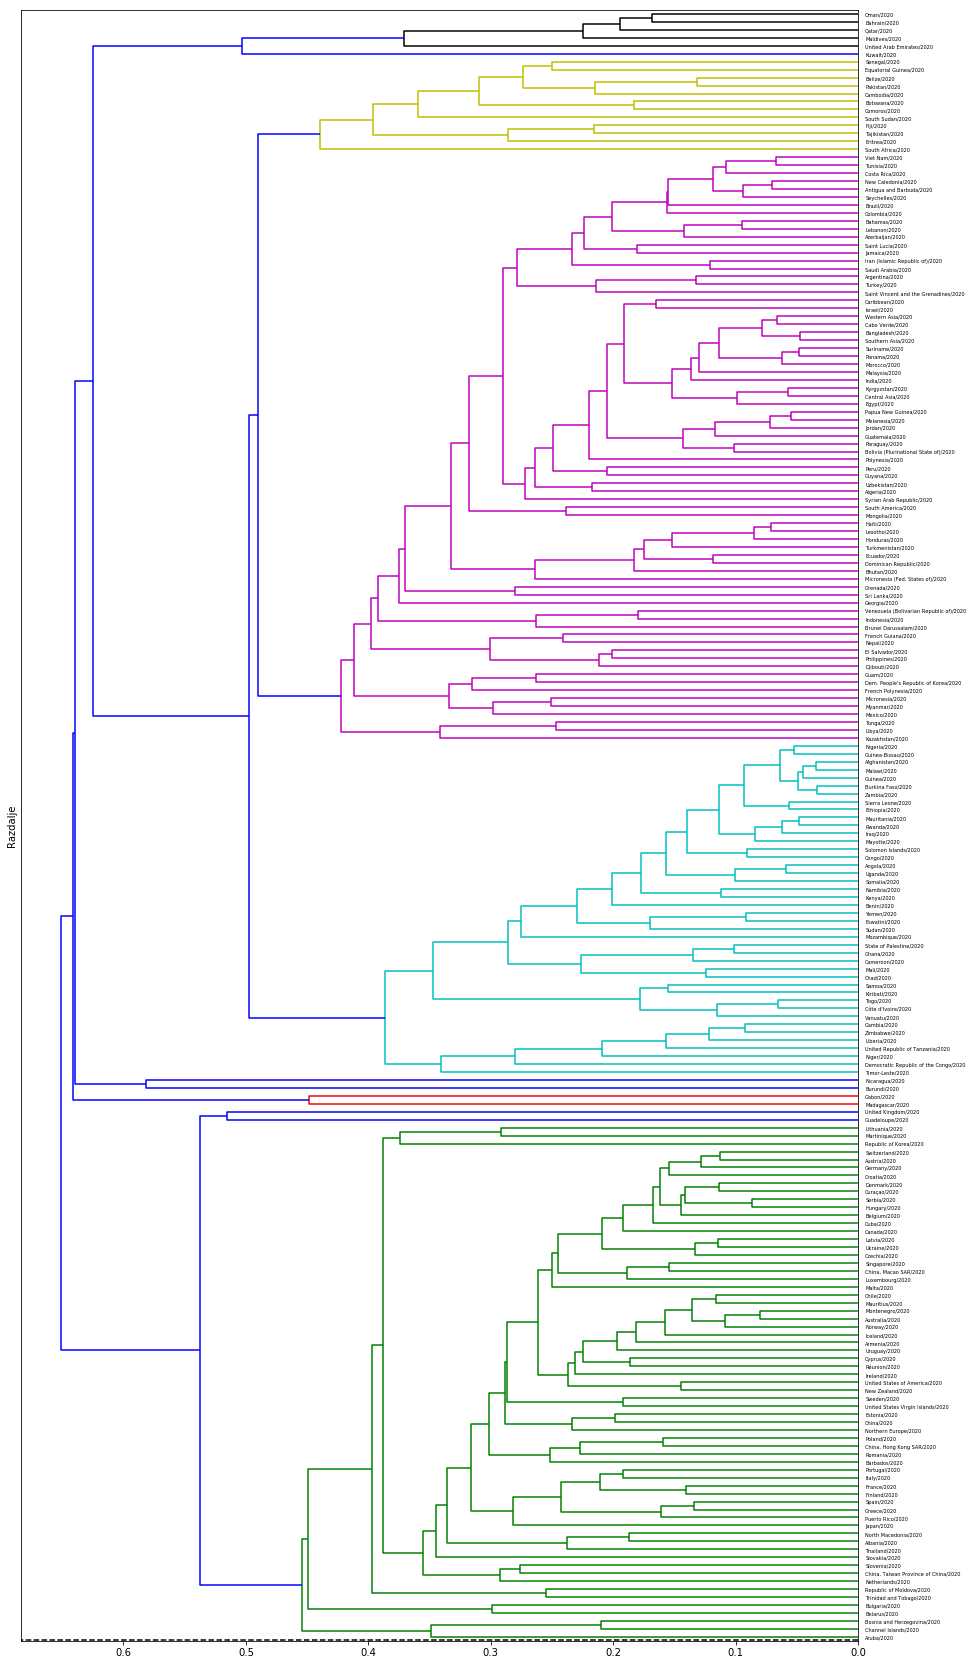

In [53]:
nmatrixNP,labelsNP = nicx.PripravaZaClusteing(main_setNP)
nicx.Clutr(nmatrixNP,labelsNP)

##### Opis podatkov

V naslednjem koraku pripravimo podatke za izdelavo modela. Podatki so v obliki slovarja, kjer so ključi države. Vsak ključ ima za vrednost polje, ki predstavlja umrljivost za vsak mesec v letu. Izbrali smo leto 2015.

In [54]:
# Create a dictionary with country for key and array of deaths per each month per million eg. {"Slovenia": [2,3,5,2,4,2,4,5,3,2,4,5]}
monthDeathDict = jaka.createMonthDeathDictionary(deathDataFrame,dataFrame,countryList,months)

In [55]:
# Creating matrix and labels
(matrix, labels) = jaka.createMatrixAndLabels(monthDeathDict)

In [56]:
# Create a linkage
mortalityLinkage = jaka.createLinkage(matrix)

Graf prikazuje, katere države si si med sabo najbolj podobne po stopnji mesečne umrljivosti skozi leto 2015. Iz podatkov lahko vidimo, da imajo države s podobno geografsko pozicijo podobne stopnje smrtnosti. V glavnem je model razdelil države na 2 večji skupini. Kar opazimo je to, da je v zeleni več držav nižje razvitosti. (ne vse, ampak več kot v rdeči)

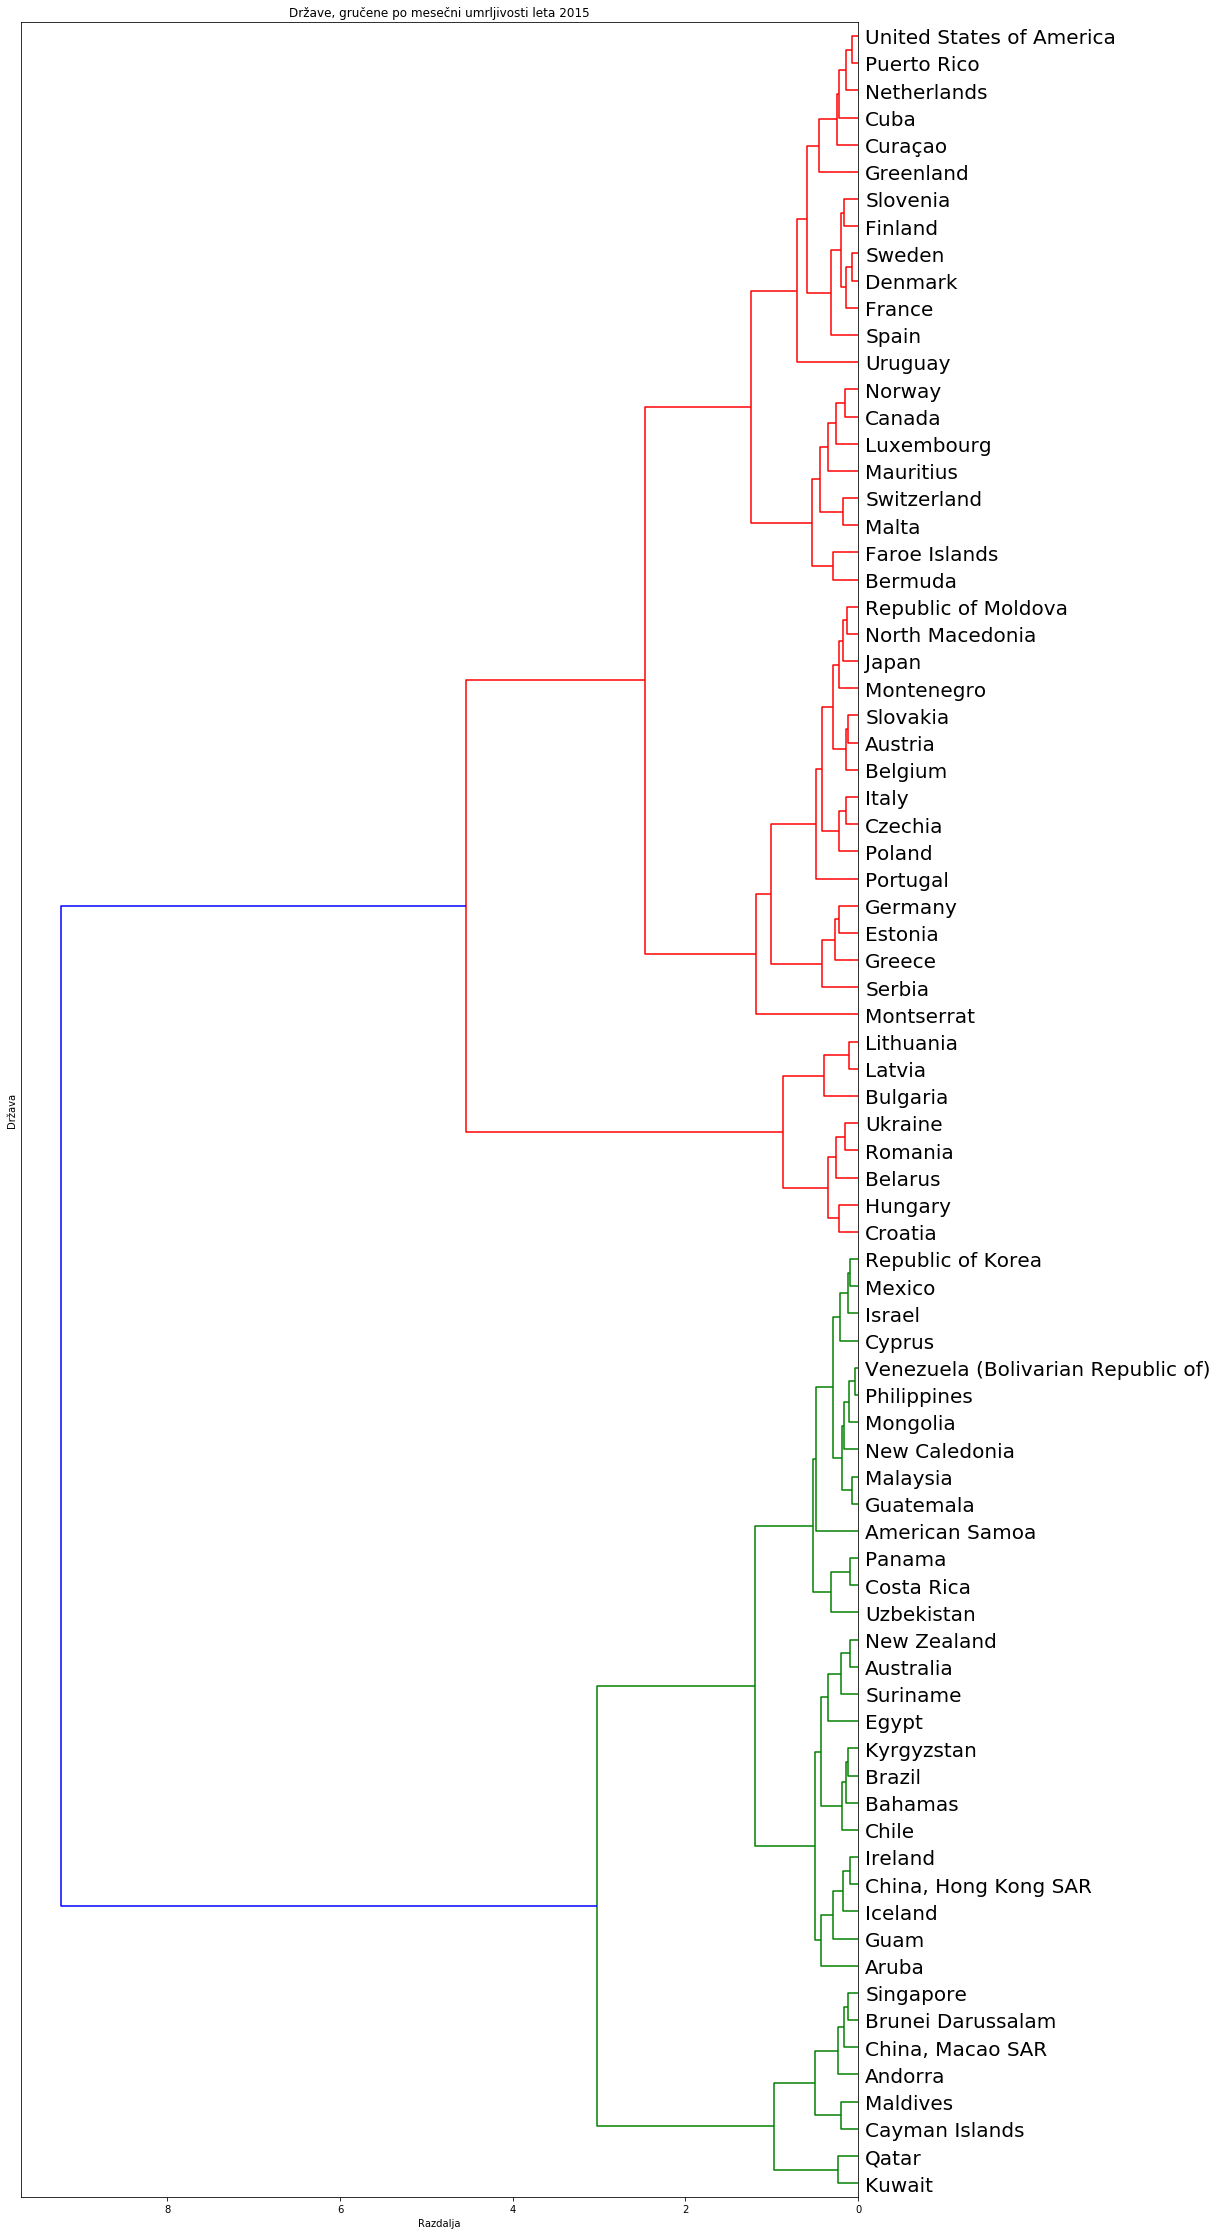

In [57]:
# Draw a dendrogram
jaka.drawDendrogram(mortalityLinkage, labels, title="Države, gručene po mesečni umrljivosti leta 2015")

# Enej

In [58]:
import os
import sys
sys.path.append(os.getcwd() + '/modules')
import enejBModule as enej

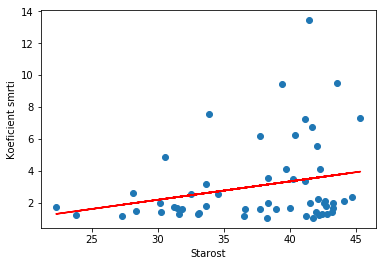

In [59]:
# ta spremenljivka je že definirana od nekoga prej
# pop_by_sex = read_population_by_sex()
pop_by_sex = enej.read_population_by_sex() 
enej.linearna(pop_by_sex)

# PRIMERJAVE Z GRIPO IN RAZMERE V ZDA

# Smrti zaradi gripe v zda po letih

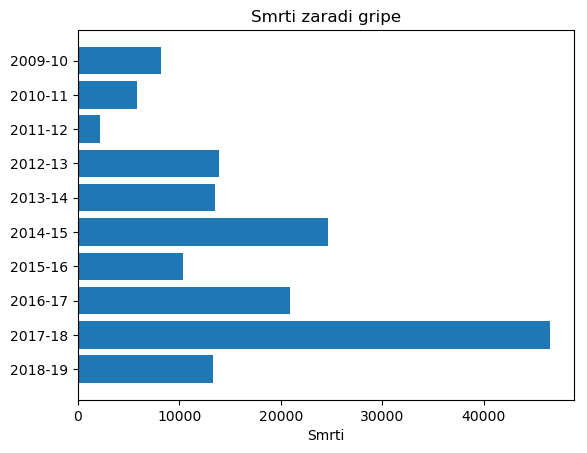

In [60]:
smr_tNP,smr_gpNP,smr_plNP,smr_gNP,seasonNP,StateNP = nicx.read_csv()
letaNP,dfgNP,dfpNP = nicx.PripravaZaGripo(seasonNP,smr_gNP,smr_plNP)
dgNP,dpNP,letaNP = nicx.PripravaLetaDGP(dfgNP,dfpNP,letaNP)
nicx.years(letaNP, dgNP)

# Smrti zaradi pljucnice v zda po letih

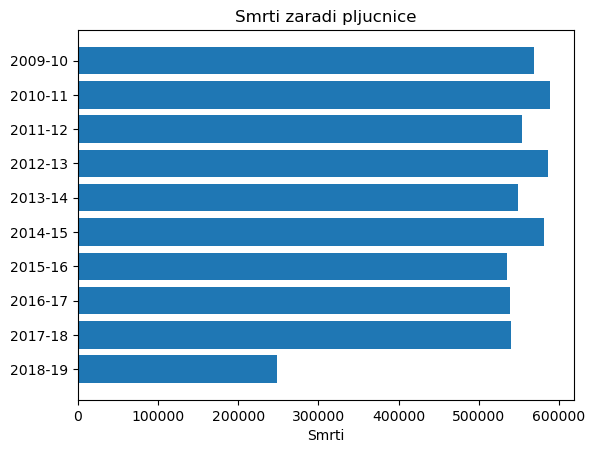

In [61]:
smr_tNP,smr_gpNP,smr_plNP,smr_gNP,seasonNP,StateNP = nicx.read_csv()
letaNP,dfgNP,dfpNP = nicx.PripravaZaGripo(seasonNP,smr_gNP,smr_plNP)
dgNP,dpNP,letaNP = nicx.PripravaLetaDGP(dfgNP,dfpNP,letaNP)
nicx.plucnca(letaNP,dpNP)

# Smrti zaradi pljučnice po zveznih državah v zda.

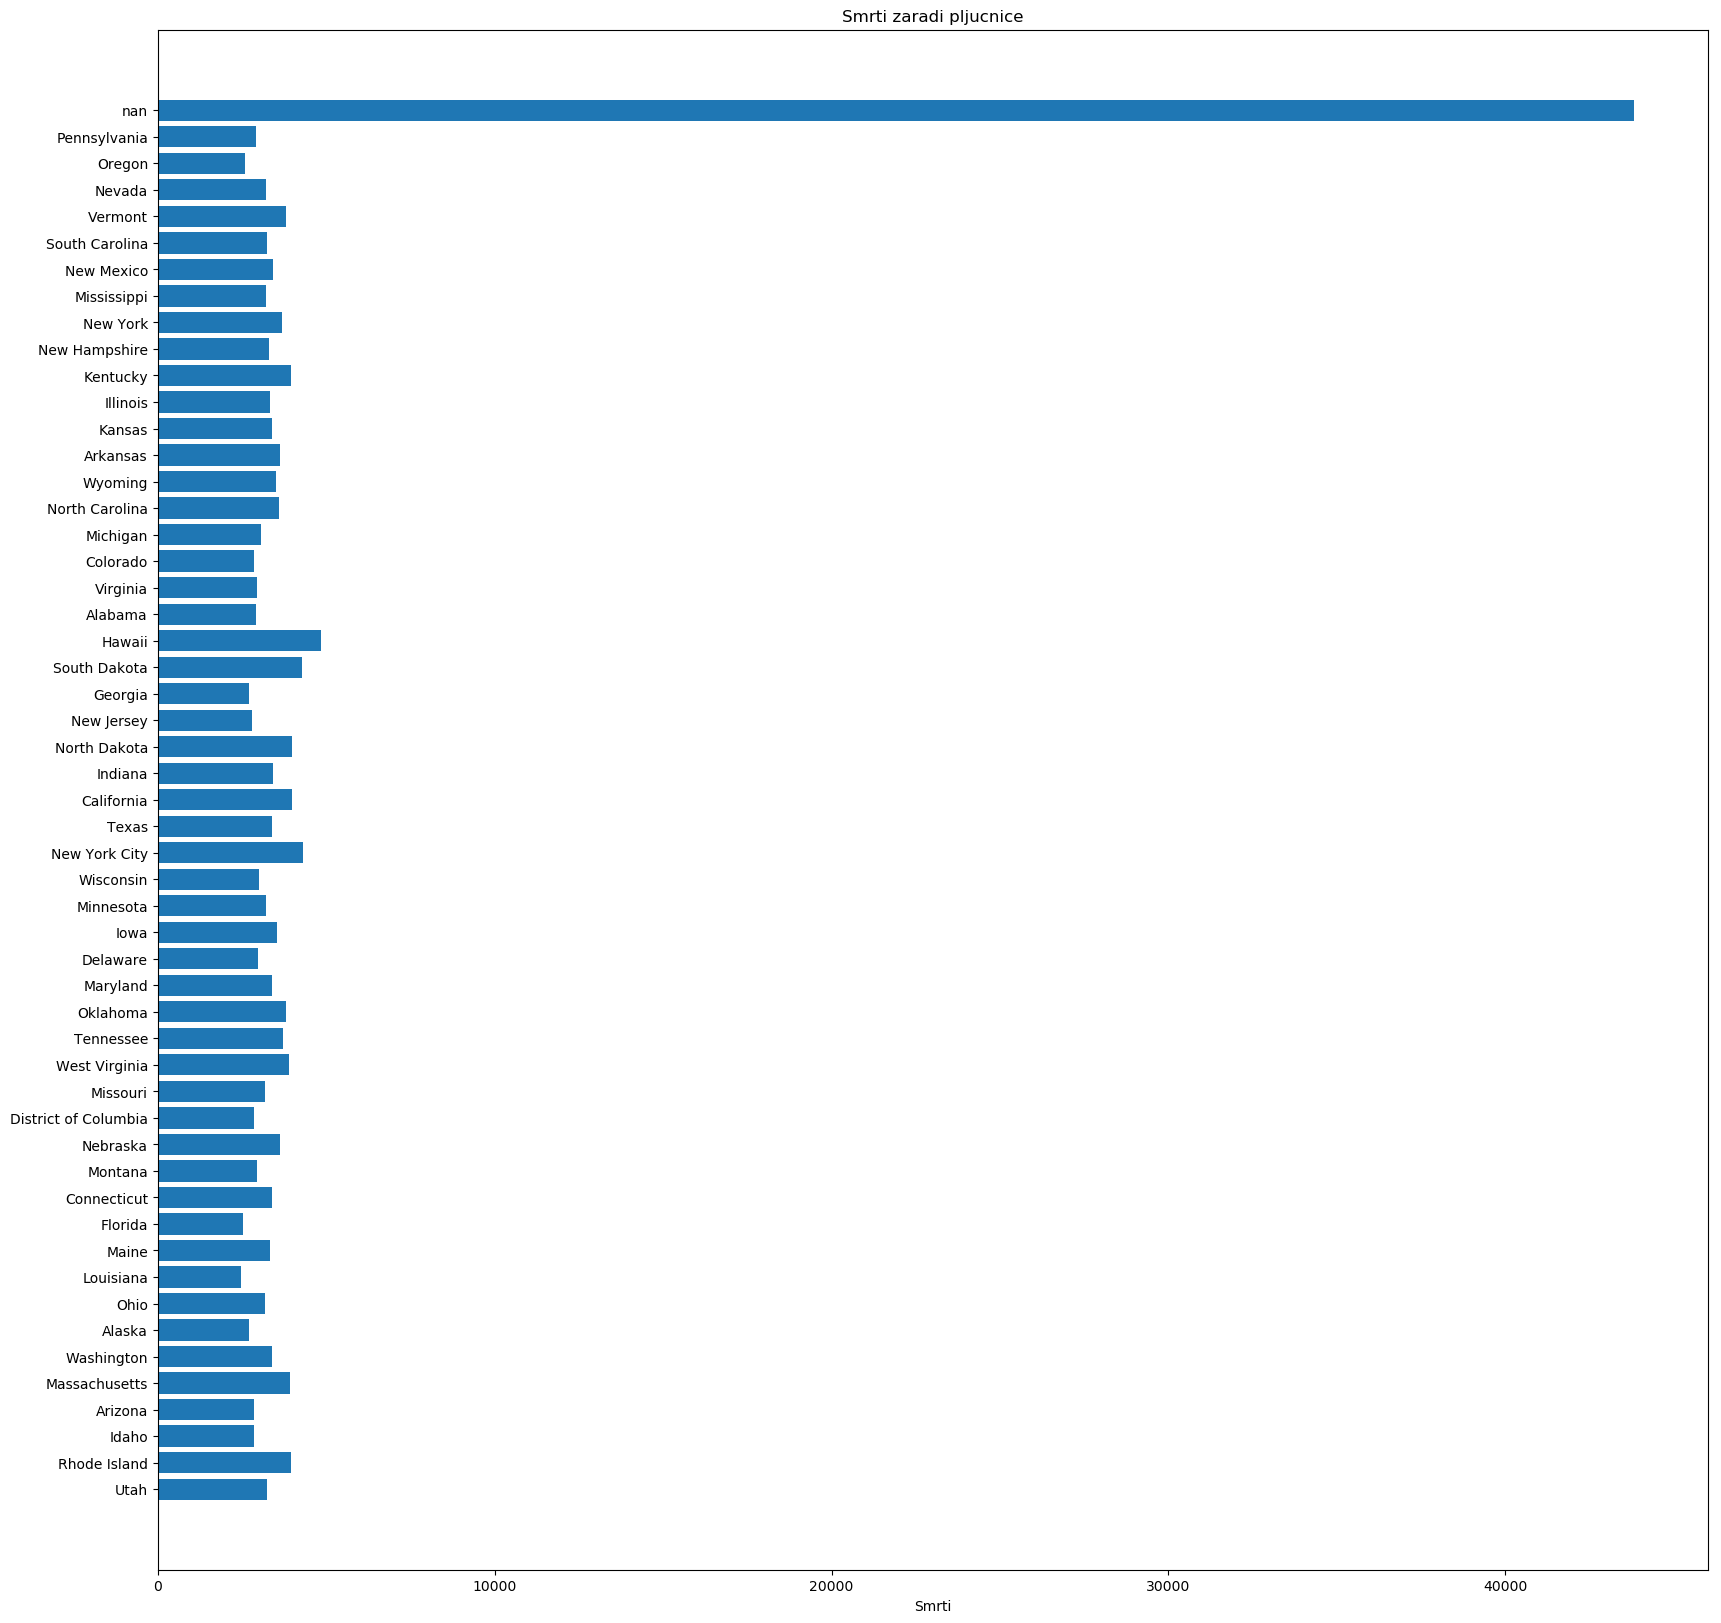

In [62]:
smr_tNP,smr_gpNP,smr_plNP,smr_gNP,seasonNP,StateNP = nicx.read_csv()
letaNP,dfgNP,dfpNP = nicx.PripravaZaGripo(seasonNP,smr_gNP,smr_plNP)
grpNP,stejtNP,vsNP = nicx.PljuvnivaSmrtiDrzava(StateNP,smr_gpNP,smr_tNP)    
nicx.smrtiZaradiP(stejtNP,grpNP)

# Smrti za Covid in gripo - Primerjava po letih

Primerjava smrti za novim COVID-19 v preteklem letu in smrtimi zaradi gripe po letih. Ugotovitev: Za covid je v 1 izmed let umrlo 2x toliko, ljudi kakor za gripo v najslabsem izmed let(epidemija gripe).

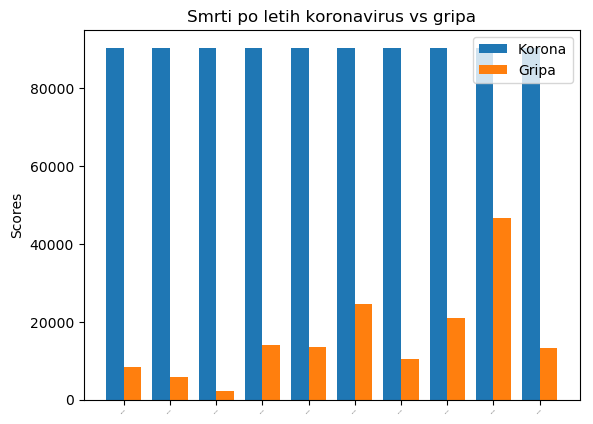

In [63]:
dgNP,dpNP,letaNP = nicx.PripravaLetaDGP(dfgNP,dfpNP,letaNP)
smrti1NP,nsNP,okuzbNP = nicx.DeathUsaCovid(americaNP,dgNP)
nicx.CorgRip(letaNP,nsNP,smrti1NP)

# STATISTIČNA OBDELAVA SMRTNOSTI

In [64]:
TOTAL_DNP,TOTAL_CNP,smrtinaprebNP,smrtnostNP = nicx.PripravaSmrtnosti(matricaNP)

In [65]:
nicx.printaj(TOTAL_DNP,TOTAL_CNP)

Skupna smrtnost po vseh drzavah: 6.7310266724359895%


# Odstotki smrti po državah

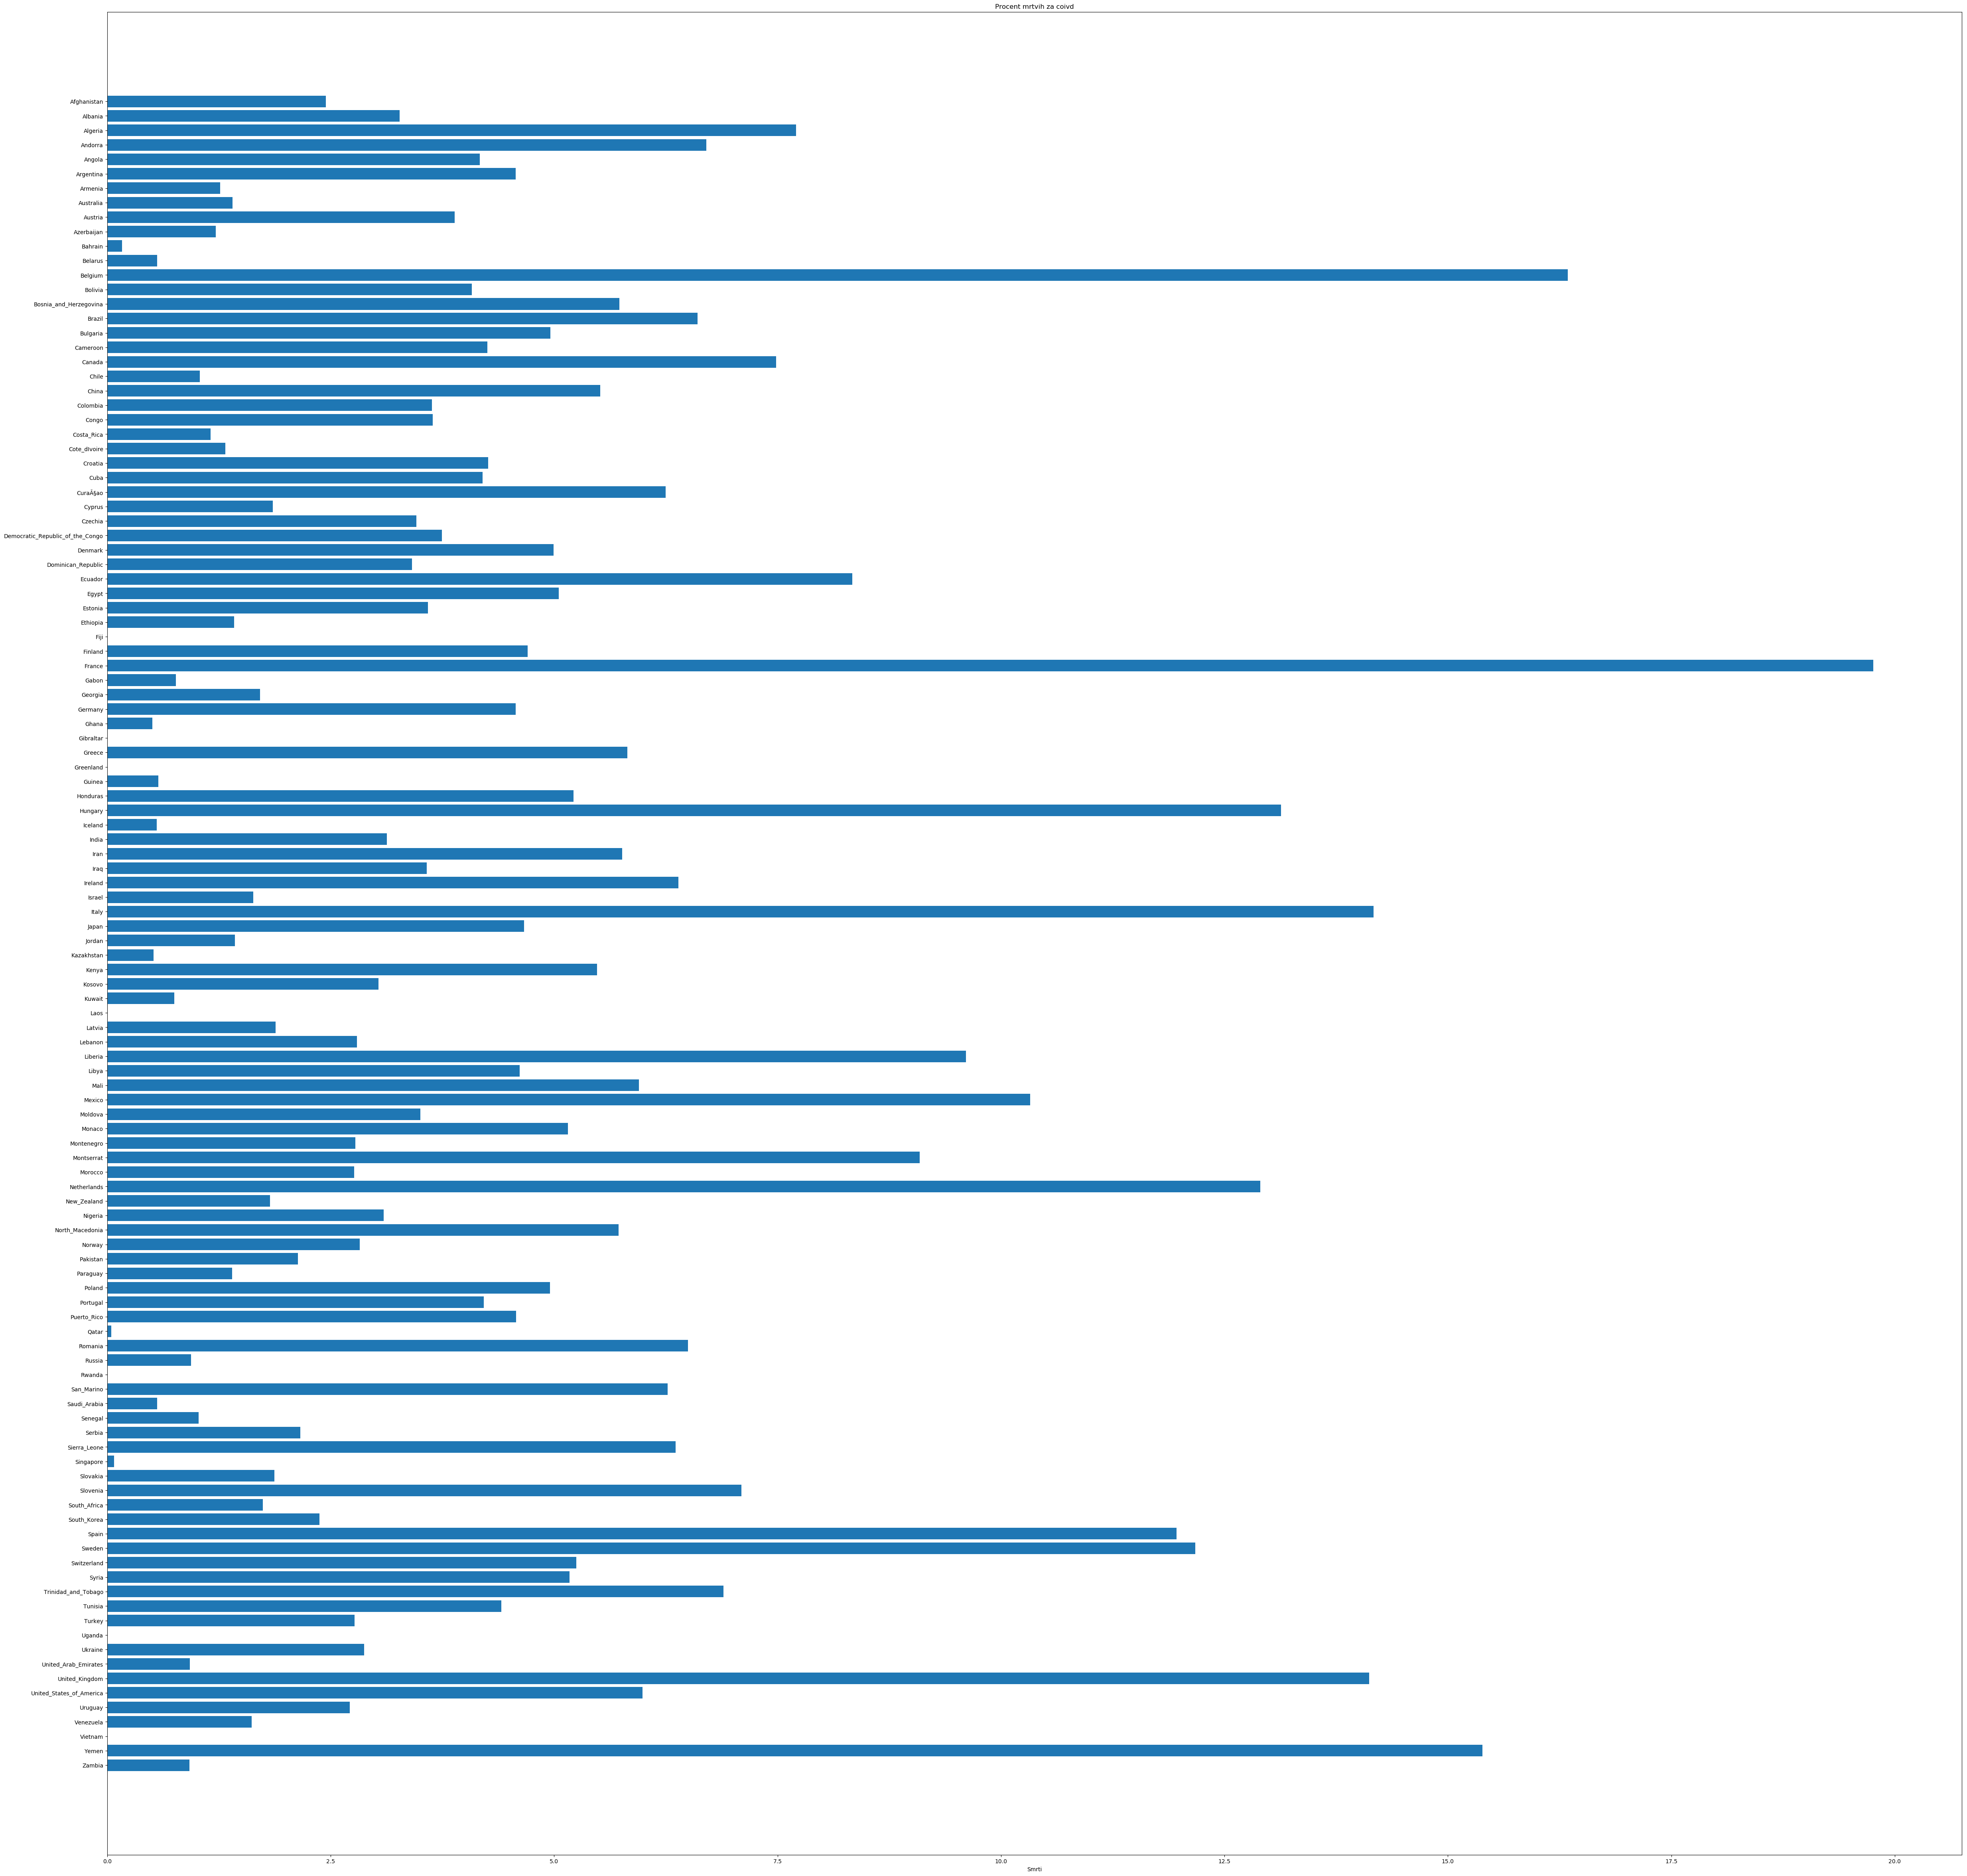

In [66]:
smrtnostiNP,smnaprebNP,drzaveNP = nicx.PripravaParamSmrt(smrtnostNP)
nicx.CoMort(drzaveNP,smrtnostiNP)

# Smrti na prebivalca po državah

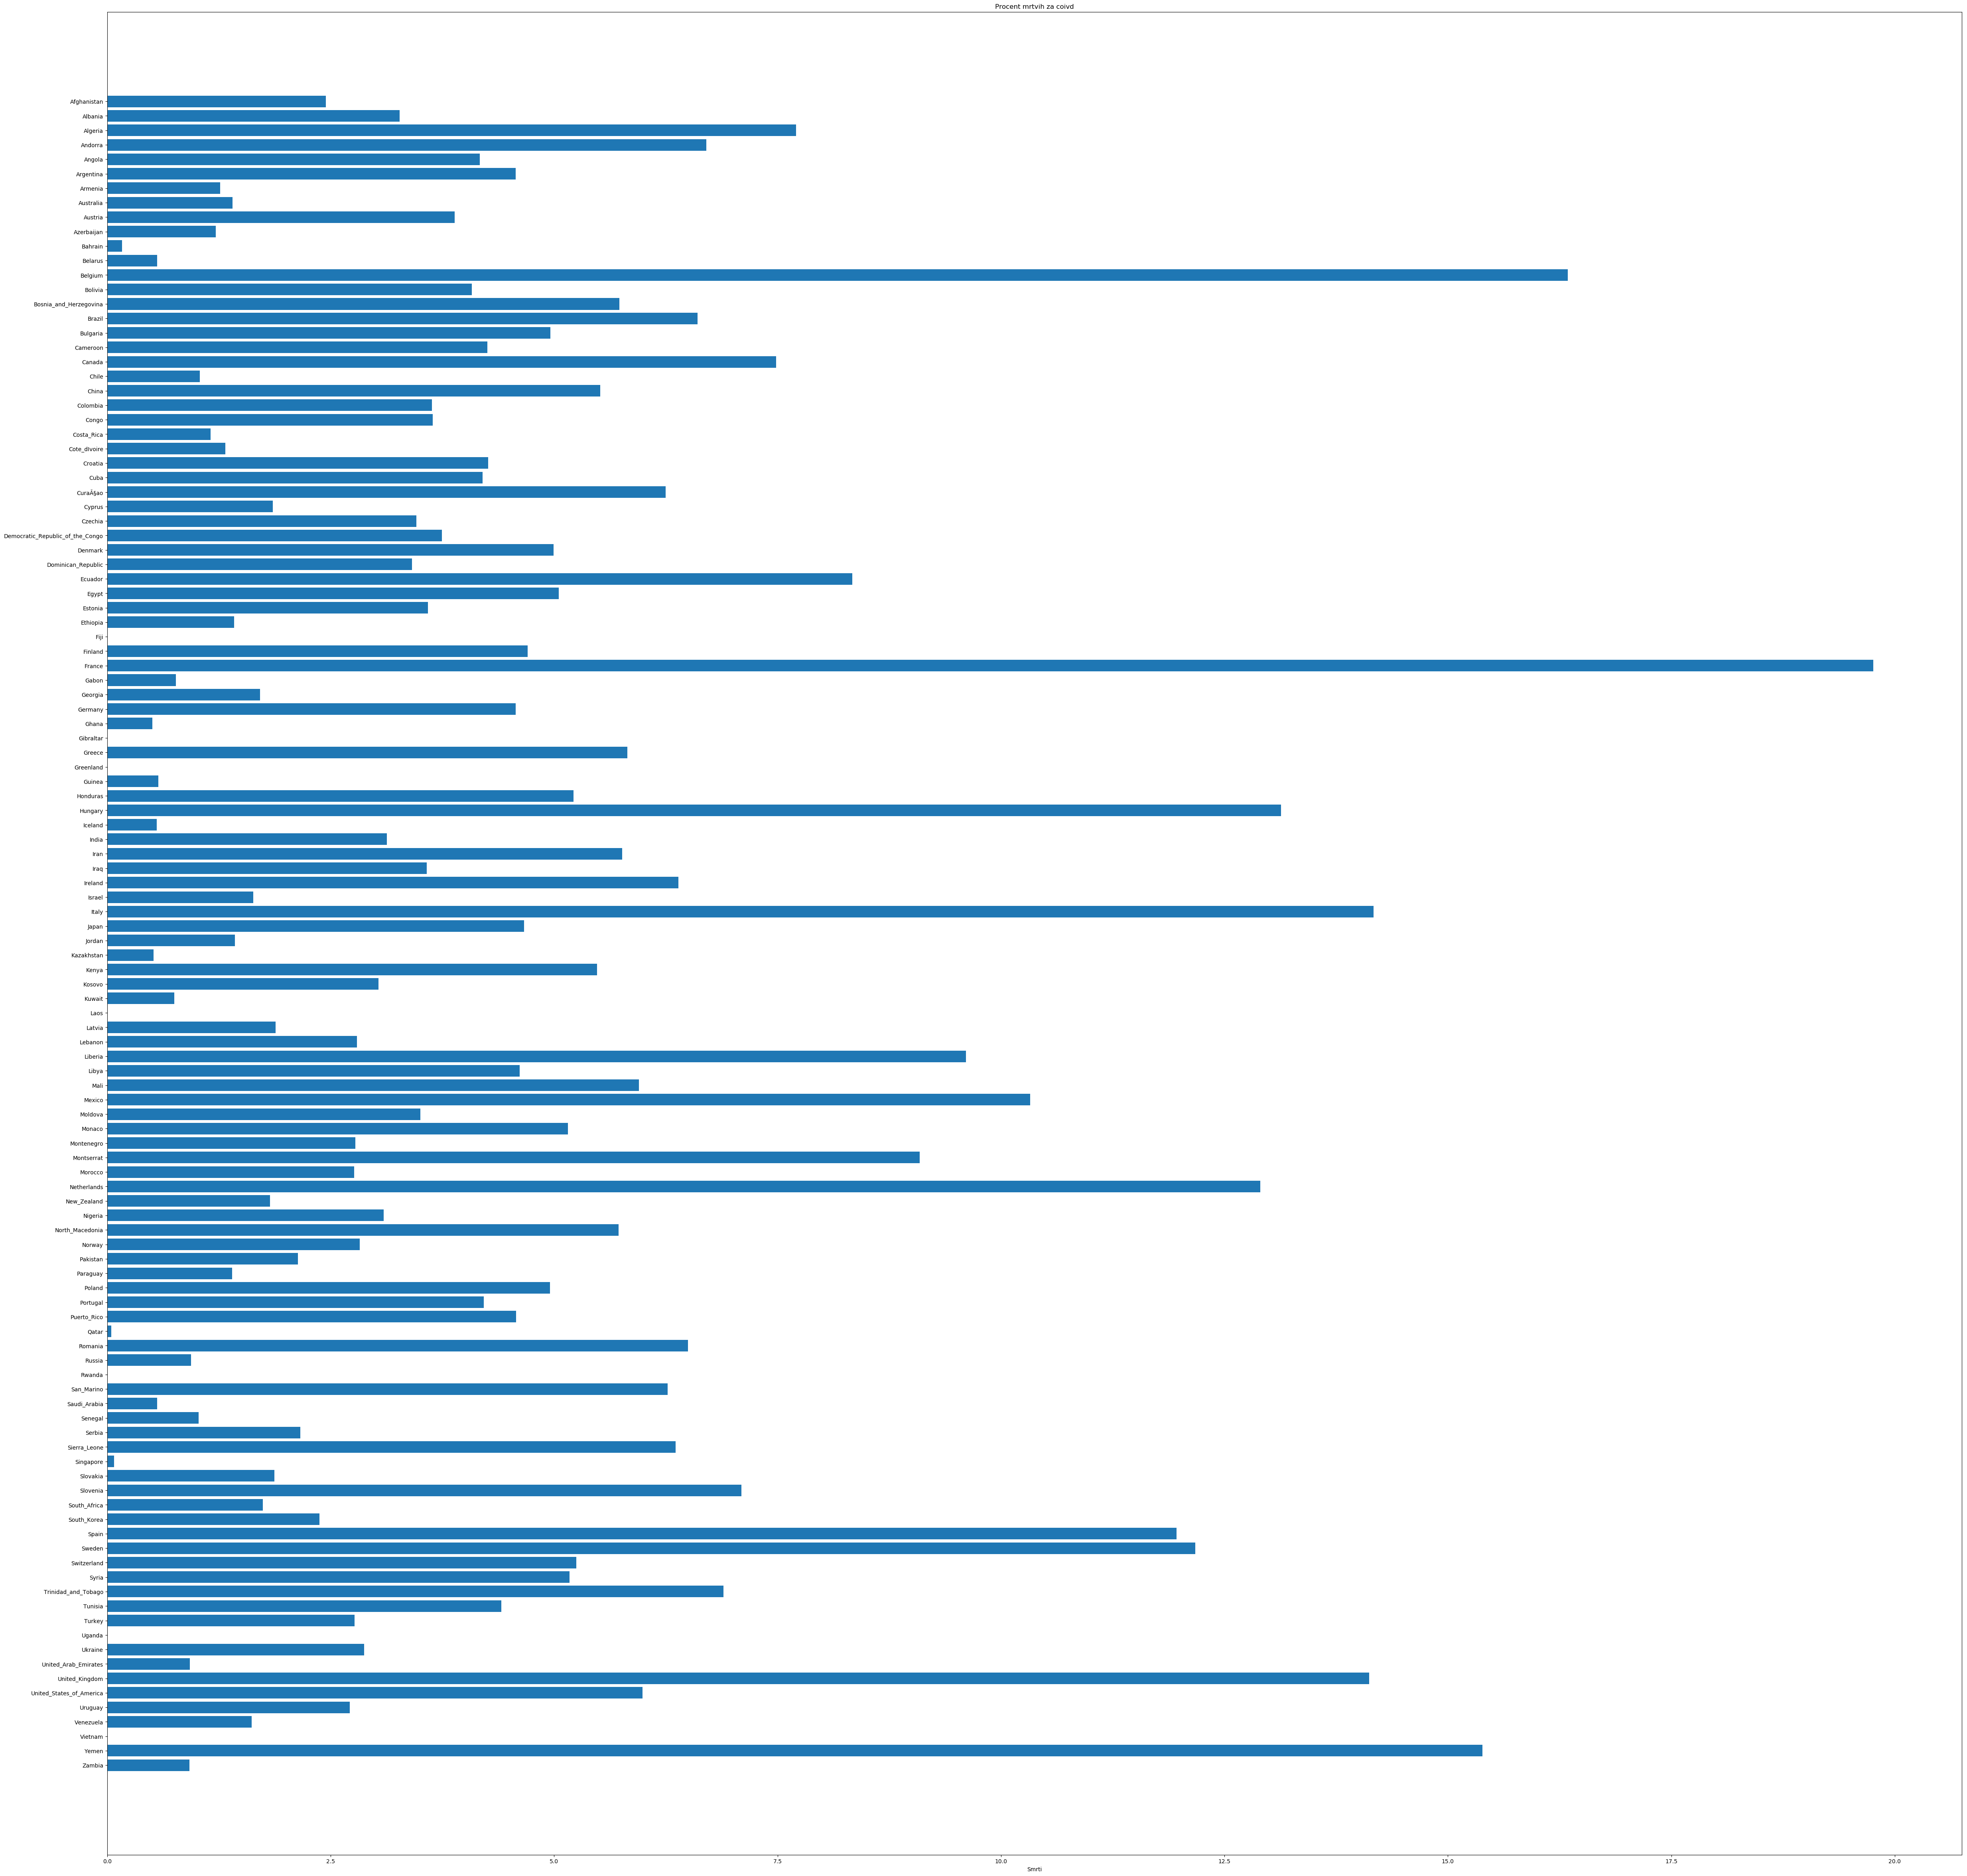

In [67]:
nicx.CntRY(drzaveNP,smnaprebNP)

# Kako se smrtnost porazdeli

C:\Users\Nikolaj\Documents\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


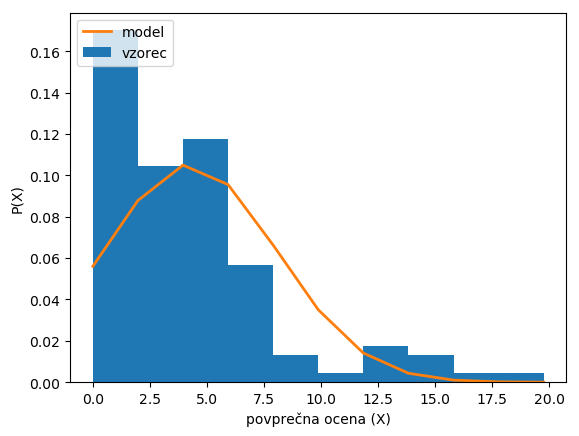

In [68]:
nNP,muNP,sigma2NP,dataNP = nicx.Ocena_statistike(smrtnostiNP)
nicx.risi(dataNP,muNP,sigma2NP)

# Najbolj uspešne države - COVID-19

In [69]:
nicx.Dobre(smrtnostNP,nNP,muNP,sigma2NP)

Anguilla
Bahrain
Belarus
Benin
Bhutan
Bonaire, Saint Eustatius and Saba
Brunei_Darussalam
Cambodia
Central_African_Republic
Djibouti
Dominica
Eritrea
Falkland_Islands_(Malvinas)
Faroe_Islands
Fiji
French_Polynesia
Gabon
Ghana
Gibraltar
Greenland
Grenada
Guinea
Guinea_Bissau
Holy_See
Iceland
Kazakhstan
Kuwait
Laos
Lesotho
Madagascar
Maldives
Mongolia
Mozambique
Namibia
Nepal
New_Caledonia
Oman
Palestine
Papua_New_Guinea
Qatar
Rwanda
Saint_Kitts_and_Nevis
Saint_Lucia
Saint_Vincent_and_the_Grenadines
Saudi_Arabia
Seychelles
Singapore
Timor_Leste
Uganda
Uzbekistan
Vietnam
Western_Sahara


# Najman uspešne države - COVID-19

In [71]:
nicx.Slabe(smrtnostNP,nNP,muNP,sigma2NP)

Belgium
British_Virgin_Islands
France
Hungary
Italy
Netherlands
Nicaragua
Sint_Maarten
Sweden
United_Kingdom
Yemen


Pri hierarhičnem gručenju, smo opazili več skupin, katere imajo sorodno starostno distribucijo. Skupine smiselno sovpadajo z realnim svetom na ta način, da imamo naprimer črno skupino v kateri so ZAE, Qatar, Bahrain, Maldivi, Oman in zanje lahko tudi v realnem svetu prepoznamo podobnosti v kulturi, načinu življenja, ekonsomskem stanju(viri nafte...) in tudi starostni porazdelitvi(precejšen del je mlajše generacije), dobimo zeleno gručo z večino evropskih držav, modro z pretežno afriškimi državami, temno modro z UK(smo že drugje opazili da deluje kot osamelec, ko smo pripravljali to gručenje) in nekaj sorodnimi državami, vijolično skupino z pretežno latinskimi državami in otoki, rumeno skupino ter rdečo skupino, ki je osamelec saj ima bistveno manj predstavnikov, in je težko opredelimo na določeno etnično ali geografsko območje. Rumena skupina določa določene dele afrike med njimi tudi nekatere razvitejše(South africa). Kako to upliva na smrti zaradi COVID? Črna skupina se naprimer z izjemo ZAE uvršča v spodnjih 5% po stevilu smrti zaradi pojava novega koronairusa, kar je zelo vrjetno posledica pomembnega atributa karkšen je starostna distribucija. Za omenjene države trdimo, da imajo pretežno mlade prebivalce za katere je virus bistveno manj nevaren kakor naprimer za države, z večjim deležem ljdui 100+,90+ itd. Države iz zelene skupine, kakor Italija, Belorusija, Francija so se uvrstile v precej večjem številu v skupino statstično najbolj značilnih držav(pri njih je stopnja smrtnosti največja), nekatere države so se kljub temu uvrstile v spodnji predel. Na to so najbolj verjetno močno uplivali dejavniki, kot so ukrepi (Njihova struktura za pomembnejša območja je opisana v drugem razdelku). Poleg tega je očitno pomembna tudi socialno-ekonomska situacija(revne afriške države se hitreje razmnožujejo in prej umirajo zaradi nižjega standarda), bogate države z specifično kulturo se klasificirajo drugam kakor klasični razviti svet ali afrika.